<a href="https://colab.research.google.com/github/seeverblog/BCDU-Ne/blob/master/Merge_InceptionV3_Resnetinception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/DATA RD/')
files = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATA KAGGLE/DATA GLOB/*')
files2 = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/MESEIDOR/DATA GLOB/*')

In [5]:
len (files), len (files2)

(7723, 1200)

In [6]:
train_imgs = [fn for fn in files+files2]
len(train_imgs)

8923

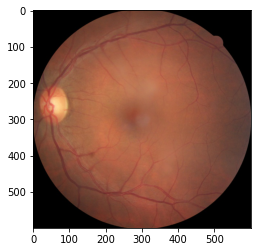

In [7]:
import matplotlib.image as mpimg
for ima in train_imgs[0:1]:
     img=mpimg.imread(ima)
     imgplot = plt.imshow(img)
     plt.show()

In [0]:
nrows = 299
ncolumns = 299
channels = 3  

def read_and_process_image(list_of_images):
    
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Normal' in image:
            y.append(0)
        elif 'Mild' in image:
            y.append(1)
        elif 'Moderate' in image:
            y.append(2)
        elif 'Severe' in image:
            y.append(3)

    
    return X, y

In [0]:
X, y = read_and_process_image(train_imgs)

In [0]:
import seaborn as sns
import gc 
gc.collect()

#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Total images of each class')

In [0]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=np.array(y),random_state=2)


In [0]:
print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

In [0]:
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

In [0]:
y_train_ohe = pd.get_dummies(y_train)
y_val_ohe=pd.get_dummies(y_val)

y_train_ohe.shape,y_val_ohe.shape

In [0]:
f1_base =tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)
f1_x = f1_base.output
f1_x = tf.keras.layers.GlobalAveragePooling2D()(f1_x)

f2_base =tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False) 
f2_x = f2_base.output
f2_x = tf.keras.layers.GlobalAveragePooling2D()(f2_x)

In [0]:
x = tf.keras.layers.concatenate([f1_x, f2_x])
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(4, activation='sigmoid', name="main_output")(x)
model =tf.keras.models.Model(inputs=[f1_base.input, f2_base.input],outputs=[x])

In [0]:
for layer in f1_base.layers:
    layer.trainable = True

for layer in f2_base.layers:
    layer.trainable = True

In [0]:
metric_list = ["accuracy"]
optimizer = tf.keras.optimizers.Adam(lr=0.0003)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)

In [0]:
batch_size=32
# Define the image transformations here
gen =tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=666)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=666)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(X_train, X_train, y_train_ohe)
val_flow = gen_flow_for_two_inputs(X_val, X_val, y_val_ohe)

In [0]:
model.fit_generator(gen_flow, validation_data=([X_val, X_val], y_val_ohe ),
                    steps_per_epoch=len(X_train) / batch_size, epochs=100)